# STA/STC Receptive field models for LNP neurons

This notebook demonstrates spike-triggered average (STA) and spike triggered covaraiance (STC) models for neural responses. It uses the output of synthetic, Linear-Nonlinear Poisson (LNP) neurons as a data source.

Inspiration/code from:
1. _"Analysis of Neuronal Spike Trains, Deconstructed"_, by J. Aljadeff, B.J. Lansdell, A.L. Fairhall and D. Kleinfeld (2016) Neuron, 91 http://dx.doi.org/10.1016/j.neuron.2016.05.039 
2. _"Spike-triggered neural characterization"_, by Schwartz, O, Pillow, JW, Rust, NC, and Simoncelli, EP. (2006).  Journal of Vision, 6 [Code](http://pillowlab.princeton.edu/code_STC.html)

_SLH 2017_

In [1]:
import numpy as np
from scipy import linalg,signal

import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab

%matplotlib inline

In [2]:
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

## Stimuli

Stimuli for this demo are 1) Gaussian white noise $\mathbf{s_g}$, which is a specific example of an "elliptical" distrubution where the STA will yield the best estimate of a linear receptive field, 2) correlated gaussian white noise $\mathbf{s_c}$, which will cause the naive STA to misrepresent the features that best drive the LNP neuron. 

$$
\mathbf{s_g} : \textrm{gaussian white noise stimulus vector} \sim \mathcal{N}(\mu,\,\sigma^{2})\,.
\\
\mu = 1, \sigma^{2} = 1
\\
\mathbf{s_c} : \textrm{correlated gaussian white noise} =  \mathbf{s_g} \ast e^{-t/\tau}
\\
\tau = see\ below
$$

In [3]:
stim_len = 5000000
np.random.seed(14)

# gaussian white noise stimulus
stim_g = np.random.normal(0,1,size=stim_len)

# length of filters + correlation scale, note they are matched so this problem is much easier
nfilt = 30

# exponential filter
te = np.arange(0,nfilt)
tau = nfilt*.25
exp_filt = np.exp(-te/(tau))
exp_filt = exp_filt / linalg.norm(exp_filt)

# generate correlated gaussian white noise
stim_c = np.convolve(stim_g,exp_filt)[:stim_len]

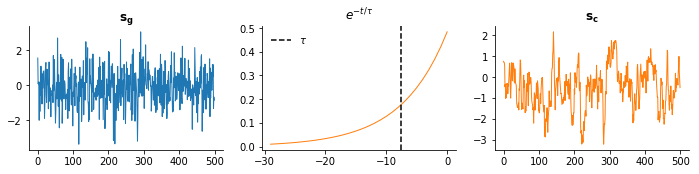

In [4]:
# Inspect signal processing
fig = plt.figure(figsize=(16,5));

ax = plt.subplot(2, 4, 1);
ax.plot(stim_g[:500],lw=1,color='C0');
ax.set_title('$\mathbf{s_g}$');

ax = plt.subplot(2, 4, 2);
ax.plot(-te,exp_filt,lw=1,color='C1');
ax.axvline(-tau,linestyle='--',color='black',label=r'$\tau$');
ax.legend(frameon=False);
ax.set_title(r'$e^{-t/\tau}$');

ax = plt.subplot(2, 4, 3);
ax.plot(stim_c[:500],lw=1,color='C1');
ax.set_title('$\mathbf{s_c}$');

## LNP Cascade

This LNP casecade has two (nonorthogonal) filters and static nonlinearity to define the rate of a poisson process. This is a pretty straighforward model, we want several thousand spikes to recover a good estimate of the feature vectors. The correlated noise will tend to drive more spikes because of our filter widths.

In [5]:
def calc_lnp_output(stim,filt1,filt2,w1=50,w2=50):
    
    # Linear output for each filter
    cf1 = np.convolve(stim,filt1)[:stim_len]
    cf2 = np.convolve(stim,filt2)[:stim_len]
    
    # nonlinearity, with weighted sum
    rate = w1*np.maximum(cf1,0) + w2*np.maximum(cf2,0)
    #rate = w1/10*cf1**2 + w2/10*cf2**2
    
    # Get spiking output, simple method
    spikes = np.random.poisson(rate*tbin)
    
    return (spikes,rate)

In [6]:
# Time resolution for this simulation is miliseconds
tbin = 0.001

tf = np.arange(0,nfilt)

# Filter 1: Simple ingegrating alpha-like function filter
alpha1 = 0.4
filt1 = alpha1 * np.exp(-alpha1*tf) * (alpha1*tf)**4

# Filter 2: Biphasic filter 
alpha2 = 0.75
filt2 = alpha2 * np.exp(-alpha2*tf) * ((alpha2*tf)**5/np.math.factorial(5) - (alpha2*tf)**7/np.math.factorial(7))

# Normalize filters
filt1 = filt1 / linalg.norm(filt1)
filt2 = filt2 / linalg.norm(filt2)

# Weights for each filter
w1 = 20
w2 = 20

# Get spiking output for both stimuli
spikes_g,rate_g = calc_lnp_output(stim_g,filt1,filt2,w1=w1,w2=w2)
spikes_c,rate_c = calc_lnp_output(stim_c,filt1,filt2,w1=w1,w2=w2)

n_spikes_g = np.sum(spikes_g,axis=0)
n_spikes_c = np.sum(spikes_c,axis=0)
print("Gaussian noise: {} spikes\nCorrelated noise: {} spikes".format(n_spikes_g,n_spikes_c))

# weighted sum of filters for comparison with STA
filt_sum = w1*filt1+w2*filt2
filt_sum = filt_sum / linalg.norm(filt_sum)

Gaussian noise: 79659 spikes
Correlated noise: 189105 spikes


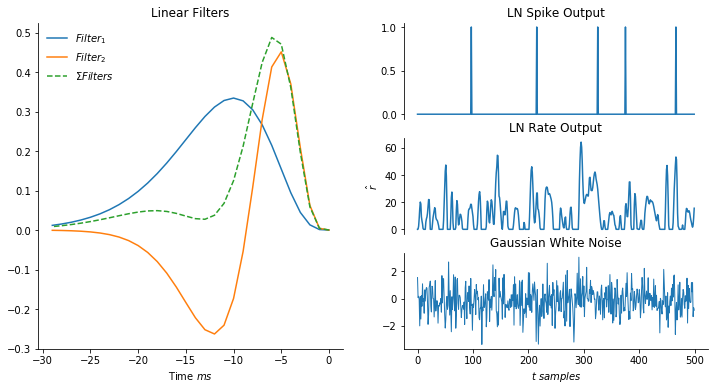

In [7]:
# Inspect LNP Cascade
fig = plt.figure(figsize=(12,6));

# Plot the linear filters and naive sum
ax1 = plt.subplot(1, 2, 1);
ax1.plot(-tf,filt1,label='$Filter_1$');
ax1.hold
ax1.plot(-tf,filt2,label='$Filter_2$');
ax1.plot(-tf,filt_sum,label='$\Sigma{} Filters$',linestyle='--');
ax1.legend(frameon=False);
ax1.set_title('Linear Filters');
ax1.set_xlabel('Time $ms$');

# Plot rate output
ax2 = plt.subplot(3, 2, 2);
ax2.plot(spikes_g[:500],color='C0');
ax2.xaxis.set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.set_title("LN Spike Output");

ax2 = plt.subplot(3, 2, 4);
ax2.plot(rate_g[:500],color='C0');
ax2.xaxis.set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.set_title("LN Rate Output");
ax2.set_ylabel(r"$\hat{r}$");

ax2 = plt.subplot(3, 2, 6);
ax2.plot(stim_g[:500],lw=1,color='C0');
ax2.set_title("Gaussian White Noise");
ax2.set_xlabel(r"$t\ samples$");

## STA +/- whitening

Simple calculation of the spike-triggered average, accounting for stimulus correlations if whitened.

It is very easy to calculate the STA and whitened STA using the design matrix from regression analysis (see J Pillow's GLM demo). In this case it is just several copies of the stimulus shifted different amounts in time (with zero padding) in each in a column. It is easier to look at the matrix below to see why this is useful...

In [8]:
def make_design_mat(stim,nfilt):
    pad = np.zeros(nfilt-1)
    pad_stim = np.concatenate((pad,stim))    
    design_mat = linalg.hankel(c=pad_stim[0:1-nfilt],r=stim[-nfilt:])

    return design_mat

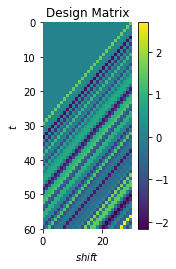

In [9]:
d_mat_g = make_design_mat(stim_g,nfilt=nfilt)
d_mat_c = make_design_mat(stim_c,nfilt=nfilt)

plt.figure(figsize=(2,3.8))
ax = plt.subplot(1, 1, 1);
pylab.pcolormesh(d_mat_g[0:nfilt*2,:]);
pylab.colorbar();
ax.invert_yaxis();
ax.set_title('Design Matrix');
ax.set_ylabel(r"$t$");
ax.set_xlabel(r"$shift$");
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

In [10]:
# Calculate STA in one line!
sta_g = np.dot(d_mat_g.T,spikes_g) / n_spikes_g
sta_g = sta_g / linalg.norm(sta_g)

sta_c = np.dot(d_mat_c.T,spikes_c) / n_spikes_c
sta_c = sta_c / linalg.norm(sta_c)

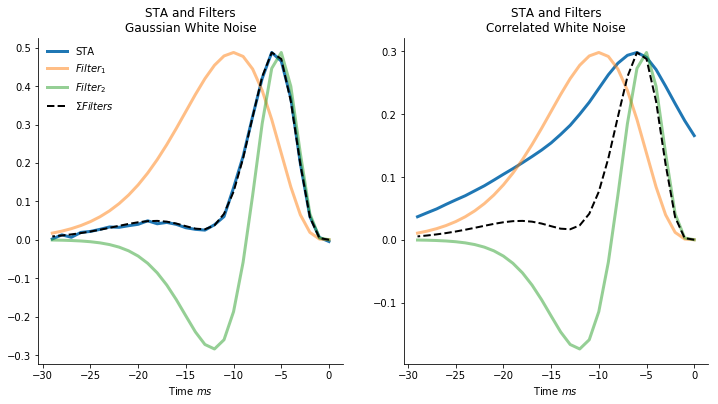

In [11]:
# Look at naive filters
fig = plt.figure(figsize=(12,6));

# Plot the linear filters and naive sum
ax1 = plt.subplot(1, 2, 1);
ax1.plot(-tf,sta_g[::-1],label='STA',lw=3,color='C0');
ax1.hold
ax1.plot(-tf,filt1/np.max(filt1)*np.max(sta_g),label='$Filter_1$',lw=3,alpha=.5,color='C1');
ax1.plot(-tf,filt2/np.max(filt2)*np.max(sta_g),label='$Filter_2$',lw=3,alpha=.5,color='C2');
ax1.plot(-tf,filt_sum/np.max(filt_sum)*np.max(sta_g),label='$\Sigma{} Filters$',linestyle='--',lw=2,alpha=1,color='k');
ax1.legend(frameon=False);
ax1.set_title('STA and Filters\nGaussian White Noise');
ax1.set_xlabel('Time $ms$');

# Plot the linear filters and naive sum
ax1 = plt.subplot(1, 2, 2);
ax1.plot(-tf,sta_c[::-1],label='STA',lw=3,color='C0');
ax1.hold
ax1.plot(-tf,filt1/np.max(filt1)*np.max(sta_c),label='$Filter_1$',lw=3,alpha=.5,color='C1');
ax1.plot(-tf,filt2/np.max(filt2)*np.max(sta_c),label='$Filter_2$',lw=3,alpha=.5,color='C2');
ax1.plot(-tf,filt_sum/np.max(filt_sum)*np.max(sta_c),label='$\Sigma{} Filters$',linestyle='--',lw=2,alpha=1,color='k');
#ax1.legend(frameon=False);
ax1.set_title('STA and Filters\nCorrelated White Noise');
ax1.set_xlabel('Time $ms$');

In [12]:
def calc_cov_mat(design_mat,spikes=None):
    """
    Calculate the stimulus covariance matrix from design matrix
    optionally make it spike triggered.
    
    spikes has same number of entries as design matrix has rows
    """
    if spikes is None:
        # nsamps for whole stimulus, mu for whole stimulus
        nsamps = design_mat.shape[0]
        mu = np.mean(design_mat,axis=0)
        D = design_mat
    else:
        # nsamps is num spikes, mu is spike triggered average
        nsamps = np.sum(spikes)
        mu = np.dot(design_mat.T,spikes) / nsamps
        D = design_mat[spikes > 0]

    # Average values, unbiased
    M = np.outer(mu.T,mu) * (nsamps/(nsamps-1))
    # Subtract off mean
    C = (np.dot(D.T,D)/(nsamps-1)) - M
    
    return(C,mu)

In [21]:
# Caclulate the stimulus covariance matrix
C = calc_cov_mat(d_mat_c)[0]

# Normalize the STA by covariance matrix

#ridge = .5
#C_inv = linalg.inv(C + ridge*np.eye(C.shape[0]))
rcond=.025
C_inv,rank = linalg.pinv(C,rcond=rcond,return_rank=True)

w_sta_g = np.dot(C_inv.T,sta_g)
w_sta_g = w_sta_g / linalg.norm(w_sta_g)

print("Rank of pseudoinverse matrix : {}".format(rank))

Rank of pseudoinverse matrix : 10


In [26]:
u,s,v = linalg.svd(C)

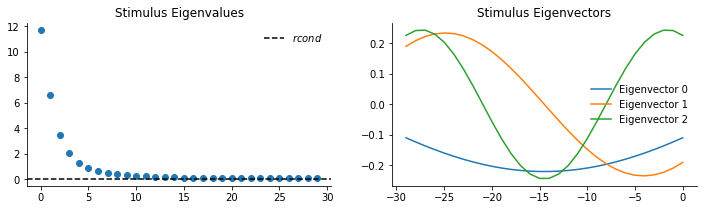

In [22]:
# Look at naive filters
fig = plt.figure(figsize=(12,3));

# Plot the linear filters and naive sum
ax1 = plt.subplot(1, 2, 1);
ax1.plot(s,'o');
ax1.hold
ax1.axhline(rcond,linestyle='--',color='black',label=r'$rcond$');
ax1.set_title('Stimulus Eigenvalues');
ax1.legend(frameon=False);

ax2 = plt.subplot(1, 2, 2);
for i in range(3):
    ax2.plot(-tf,u[:,i],'-',label="Eigenvector " + str(i));
    ax2.hold
ax2.set_title('Stimulus Eigenvectors');
ax2.legend(frameon=False);

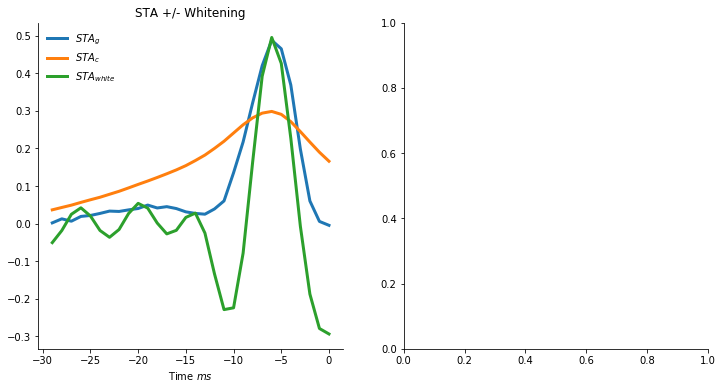

In [25]:
fig = plt.figure(figsize=(12,6));

# Plot the linear filters and naive sum
ax1 = plt.subplot(1, 2, 1);
ax1.plot(-tf,sta_g[::-1],label='$STA_{g}$',lw=3,color='C0');
ax1.hold
ax1.plot(-tf,sta_c[::-1],label='$STA_{c}$',lw=3,color='C1');
ax1.plot(-tf,w_sta_g[::-1],label='$STA_{white}$',lw=3,color='C2');
ax1.legend(frameon=False);
ax1.set_title('STA +/- Whitening');
ax1.set_xlabel('Time $ms$');

ax2 = plt.subplot(1, 2, 2);

## STC +/- whitening

Calculate the spike-triggered covariance of the stimulus. Test regularization on the matrix inversion too e.g. `np.pinv()`.